In [122]:
import numpy as np
%load_ext autoreload
%autoreload 2
import helper_functions as hp
import matplotlib.pyplot as plt
import gc
from sklearn.preprocessing import OneHotEncoder
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from keras import backend as K
import py_compile



The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [123]:
segmented_naip_images_tif, segmented_naip_new_labels = hp.segmented_dataset_reader('naip_2018_chips_128m_3class_128stride_segment')
segmented_naip_images_tif = segmented_naip_images_tif[:,:,:,0:3]
segmented_naip_new_labels = segmented_naip_new_labels[:,:,:,0]

reading in 4762 images


In [124]:
print(segmented_naip_new_labels.shape)
print(segmented_naip_images_tif.shape)

(4762, 128, 128)
(4762, 128, 128, 3)


0.7529411764705882 0.0392156862745098
float64
(128, 128, 3)


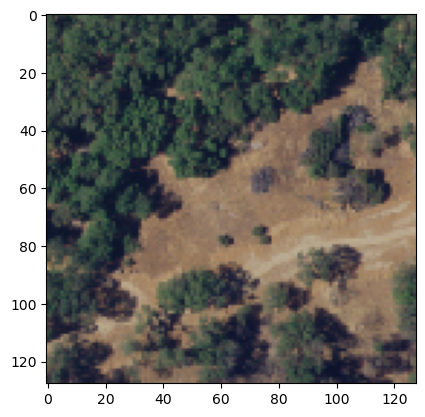

In [125]:
img = segmented_naip_images_tif[10]
print(img.max(),img.min())
print(img.dtype)
print(img.shape)
plt.imshow(img)

(128, 128)
[0 1 2 3]
3 0
uint16


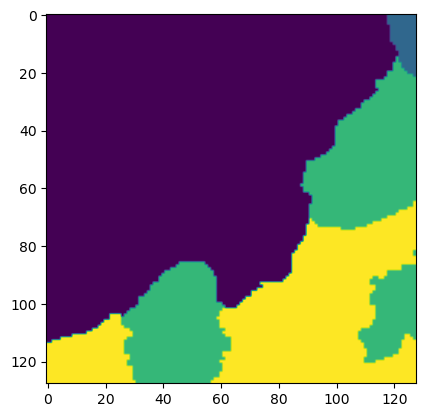

In [126]:
lbl = segmented_naip_new_labels[10,:,:]
print(lbl.shape)
print(np.unique(lbl))
print(lbl.max(),lbl.min())
print(lbl.dtype)
plt.imshow(lbl)

In [127]:
train_images, test_images, train_labels, test_labels = train_test_split(segmented_naip_images_tif, segmented_naip_new_labels, test_size=.2, shuffle=True)
print(train_images.shape,train_labels.shape)

(3809, 128, 128, 3) (3809, 128, 128)


In [128]:
train_labels.dtype

dtype('uint16')

In [129]:
train_labels_median = np.median(train_labels, axis=(1,2))
np.unique(train_labels_median, axis=0, return_counts=True)

(array([0., 1., 2., 3.]), array([ 773, 1461,  878,  697], dtype=int64))

In [130]:
model = hp.build_unet_model()
model.summary()
gc.collect()

Model: "U-Net"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 128, 128, 64  1792        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 128, 128, 64  36928       ['conv2d[0][0]']                 
                                )                                                             

50659

In [131]:
r_lr = hp.reduce_lr()
e_stop = hp.early_stop()
callbacks = [r_lr,e_stop]
gc.collect()

13

In [132]:
history = model.fit(train_images, train_labels, epochs=5, validation_data=(test_images, test_labels), batch_size=3, callbacks = callbacks)

Epoch 1/5
1270/1270 [==============================] - 83s 64ms/step - loss: 91.1232 - accuracy: 0.4879 - val_loss: 35.3635 - val_accuracy: 0.4917 - lr: 0.0010
Epoch 2/5
1270/1270 [==============================] - 82s 64ms/step - loss: 35.7375 - accuracy: 0.5034 - val_loss: 35.8332 - val_accuracy: 0.5374 - lr: 0.0010
Epoch 3/5
1269/1270 [============================>.] - ETA: 0s - loss: 36.4842 - accuracy: 0.5073
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
1270/1270 [==============================] - 80s 63ms/step - loss: 36.4844 - accuracy: 0.5072 - val_loss: 36.7242 - val_accuracy: 0.5362 - lr: 0.0010
Epoch 4/5
1270/1270 [==============================] - 79s 62ms/step - loss: 18.2375 - accuracy: 0.5283 - val_loss: 17.8708 - val_accuracy: 0.5586 - lr: 5.0000e-04
Epoch 5/5
1270/1270 [==============================] - 79s 62ms/step - loss: 17.3219 - accuracy: 0.5323 - val_loss: 19.2350 - val_accuracy: 0.5522 - lr: 5.0000e-04


In [ ]:
test_final = hp.get_test_accuracy(model, test_images, test_labels)
train_final = hp.get_train_accuracy(model, train_images, train_labels)

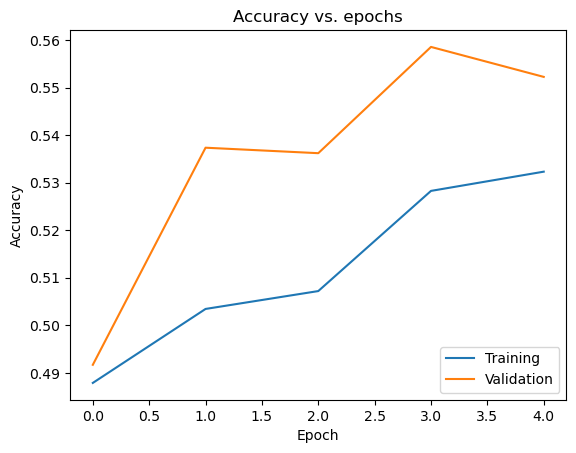

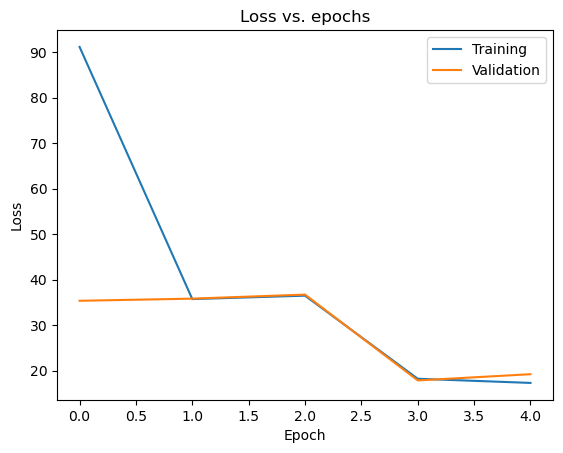

In [133]:
hp.plot_accuracy(history)
hp.plot_loss(history)

In [156]:
import tensorflow as tf
def create_mask(pred_mask):
  pred_mask = tf.argmax(pred_mask, axis=-1)
  pred_mask = pred_mask[..., tf.newaxis]
  return pred_mask

In [164]:
def display(display_list):
  plt.figure(figsize=(10, 10))

  title = ["Input Image", "True Mask", "Predicted Mask"]

  for i in range(len(display_list)):
    plt.subplot(1, len(display_list), i+1)
    plt.title(title[i])
    plt.imshow(display_list[i])
    plt.axis("off")
  plt.show()

In [165]:
def show_predictions(img,label, num=1):
    for i in range(num):
      pred_mask = model.predict(img)
      display([img[i], label[i], create_mask(pred_mask[i])])

1/1 [==============================] - 0s 17ms/step


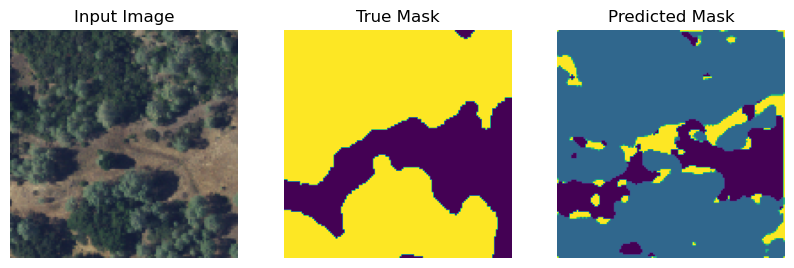

1/1 [==============================] - 0s 15ms/step


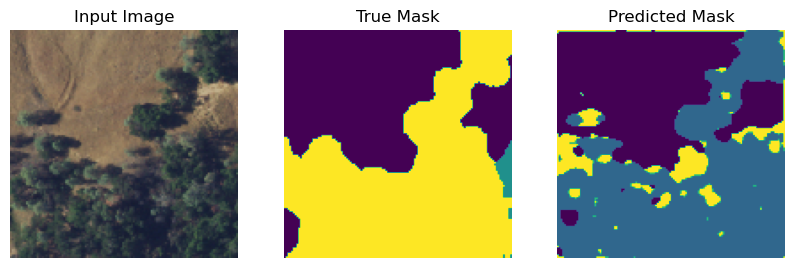

1/1 [==============================] - 0s 18ms/step


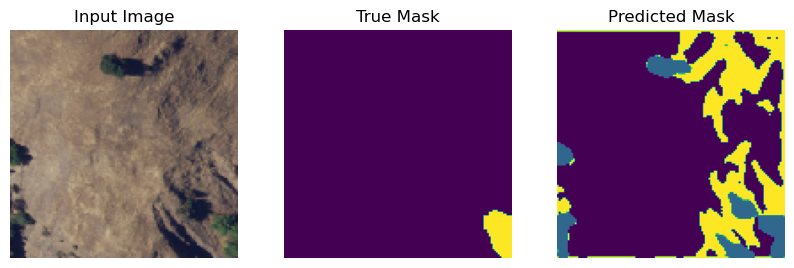

In [166]:
show_predictions(test_images[0:5],test_labels[0:5], 3)

In [169]:
print(np.unique(create_mask(model.predict(test_images))[0],return_counts=True ))
print(np.unique(test_labels[0],return_counts=True ))

30/30 [==============================] - 4s 120ms/step
(array([0, 1, 2, 3], dtype=int64), array([ 2726, 12268,   126,  1264], dtype=int64))
(array([0, 1], dtype=uint16), array([ 4690, 11694], dtype=int64))
